### Loading used packages

In [19]:
import os
import numpy as np
import geopandas as gpd
import seaborn as sns
from scipy.stats import pearsonr
from matplotlib import pyplot as plt

In [26]:
# Based on the download nightlight images from dataset: NOAA/VIIRS/DNB/ANNUAL_V22 on the google earth engine.
# street network data downloaded from openstreetmap, only download in great london region, the file size is quite large 
# A shapefile with grids was built in Qgis and used Zonal statistics to get nightlight intensity for each grid.
# Using intersction analysis to get intersection between grids and street network data, which is nightlight_street_network file here.

In [2]:
# load the intersection data using geopandas
nightlight_street_network = gpd.read_file(r'nightlight_street_network.shp')

In [3]:
# check out dataframe
print(nightlight_street_network.head())

   highway waterway aerialway barrier man_made       id  road_len  \
0  primary      NaN       NaN     NaN      NaN  17432.0        18   
1  primary      NaN       NaN     NaN      NaN  17772.0        62   
2  primary      NaN       NaN     NaN      NaN  17433.0       450   
3  primary      NaN       NaN     NaN      NaN  17605.0       225   
4  primary      NaN       NaN     NaN      NaN  18104.0       251   

                                            geometry  
0  LINESTRING (694381.194 5720475.241, 694391.019...  
1  LINESTRING (695445.230 5722253.041, 695447.192...  
2  LINESTRING (694064.216 5719950.567, 694079.168...  
3  LINESTRING (694500.000 5719885.065, 694507.747...  
4  LINESTRING (696340.423 5728282.669, 696359.683...  


In [6]:
# group data with grid id to get total road length for each grid.
grouped_stats = nightlight_street_network.groupby(['id']).agg(
    total_length=('road_len', 'sum'),  # Sum the lengths within each group        # Count the number of line segments
).reset_index()

In [7]:
print(grouped_stats)

           id  total_length
0      7648.0           418
1      7820.0           538
2      7992.0           532
3      8164.0           593
4      8336.0            76
...       ...           ...
8016  31733.0           517
8017  31734.0           517
8018  31735.0           259
8019  31903.0           187
8020  31904.0           183

[8021 rows x 2 columns]


In [8]:
# load nightligh data from grids 
nightlight_grids = gpd.read_file(r'nightlight_grids.shp')

In [9]:
print(nightlight_grids.head())

    id      left        top     right     bottom  _count      _sum     _mean  \
0  1.0  643500.0  5750000.0  644000.0  5749500.0     1.0  1.730895  1.730895   
1  2.0  643500.0  5749500.0  644000.0  5749000.0     1.0  2.094511  2.094511   
2  3.0  643500.0  5749000.0  644000.0  5748500.0     1.0  1.997370  1.997370   
3  4.0  643500.0  5748500.0  644000.0  5748000.0     1.0  1.873754  1.873754   
4  5.0  643500.0  5748000.0  644000.0  5747500.0     1.0  1.907341  1.907341   

                                            geometry  
0  POLYGON ((643500.000 5750000.000, 644000.000 5...  
1  POLYGON ((643500.000 5749500.000, 644000.000 5...  
2  POLYGON ((643500.000 5749000.000, 644000.000 5...  
3  POLYGON ((643500.000 5748500.000, 644000.000 5...  
4  POLYGON ((643500.000 5748000.000, 644000.000 5...  


In [10]:
# link two dataset with geopandas merge method, to get nightlight and road length per grids
street_nightlight_data = grouped_stats.merge(nightlight_grids, on='id', how='left')

In [11]:
print(street_nightlight_data.head())

       id  total_length      left        top     right     bottom  _count  \
0  7648.0           418  665500.0  5710500.0  666000.0  5710000.0     1.0   
1  7820.0           538  666000.0  5710500.0  666500.0  5710000.0     1.0   
2  7992.0           532  666500.0  5710500.0  667000.0  5710000.0     1.0   
3  8164.0           593  667000.0  5710500.0  667500.0  5710000.0     1.0   
4  8336.0            76  667500.0  5710500.0  668000.0  5710000.0     1.0   

        _sum      _mean                                           geometry  
0  59.762184  59.762184  POLYGON ((665500.000 5710500.000, 666000.000 5...  
1  23.684908  23.684908  POLYGON ((666000.000 5710500.000, 666500.000 5...  
2  32.140236  32.140236  POLYGON ((666500.000 5710500.000, 667000.000 5...  
3  39.135761  39.135761  POLYGON ((667000.000 5710500.000, 667500.000 5...  
4  24.746420  24.746420  POLYGON ((667500.000 5710500.000, 668000.000 5...  


In [22]:
# extracting nightlight and road length per grid from dataframe
nightlight_value_per_grids = street_nightlight_data['_mean']
road_length_per_grids = street_nightlight_data['total_length']

In [24]:
# calculate correlation
corr_coef, p_value = pearsonr(road_length_per_grids, nightlight_value_per_grids)
print(f"Pearson correlation coefficient: {corr_coef:.2f}")

Pearson correlation coefficient: 0.53


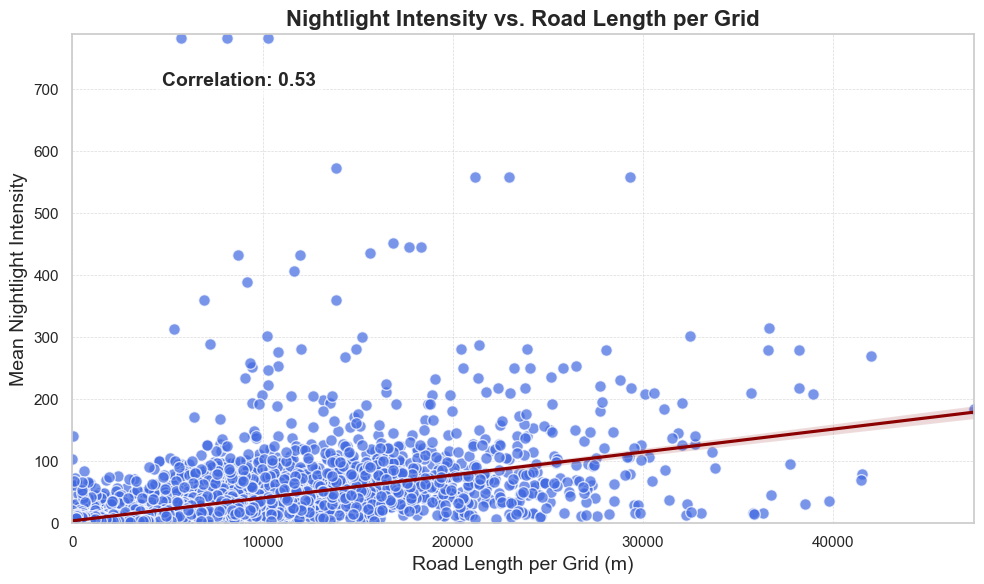

In [25]:
# plot them with seaborn and put regression line and correaltion coefficience on the figure
sns.set(style="whitegrid")

# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter = sns.regplot(x=road_length_per_grids, y=nightlight_value_per_grids, 
                      color="royalblue", line_kws={"color": "darkred"}, 
                      scatter_kws={"s": 70, "edgecolor": "w", "alpha": 0.7})

plt.text(0.1 * road_length_per_grids.max(), 
         0.9 * nightlight_value_per_grids.max(), 
         f"Correlation: {corr_coef:.2f}", 
         fontsize=14, 
         weight='bold', 
         bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.3'))

# Titles and labels
plt.title("Nightlight Intensity vs. Road Length per Grid", fontsize=16, weight='bold')
plt.xlabel("Road Length per Grid (m)", fontsize=14)
plt.ylabel("Mean Nightlight Intensity", fontsize=14)

# Add gridlines and limit scales if desired
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.xlim(0, road_length_per_grids.max() + 5)   # Add buffer for better visualization
plt.ylim(0, nightlight_value_per_grids.max() + 5)

# Show the plot
plt.tight_layout()
plt.show()